### Transforms   
데이터가 언제나 우리에게 친절한, 깔끔한 형태로 주어지지 않는다. 그래서 `Transforms`을 사용해서 
Data manipulation에 더 용이하게끔 바꿔주는 역할을 한다.  

모든 Torchvision dataset엔 2개의 파라미터가 존재함. -> transform은 feature를 수정(변경)할때 쓰고, target_transform은 정답(label)을 수정(변경)할때 사용함.  
지금 FashionMNIST의 feature는 PIL형식이고 label은 int인데, 어찌되었든 PIL 이미지 형식을 tensor로 바꿔야 하고 -> `ToTensor()`, label도 one hot encoding으로 encode해줘야함.  

In [2]:
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda # ToTensor() scales the image pixel values to [0.0, 1.0]
ds = datasets.FashionMNIST(
    root='data', # 루트 디렉토리에 데이터를 저장
    train=True, # 훈련 데이터를 가져옴
    download=True, # 루트 디렉토리에 데이터가 없다면 인터넷에서 다운로드
    transform=ToTensor(),# FashionMNIST의 데이터셋(feature(image), label)을 텐서로 변환
    target_transform = Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    # target_transform은 레이블을 원-핫 인코딩된 텐서로 변환
    # Lambda는 사용자 정의 람다 함수를 정의(user defined lambda func)
    # torch.zeros(10, dtype=torch.float)는 10개의 0으로 채워진 텐서를 생성,
    # scatter_함수는 주어진 인덱스에 값을 할당하는 함수 scatter(dim, index, src)
)

아래 그림을 보자  
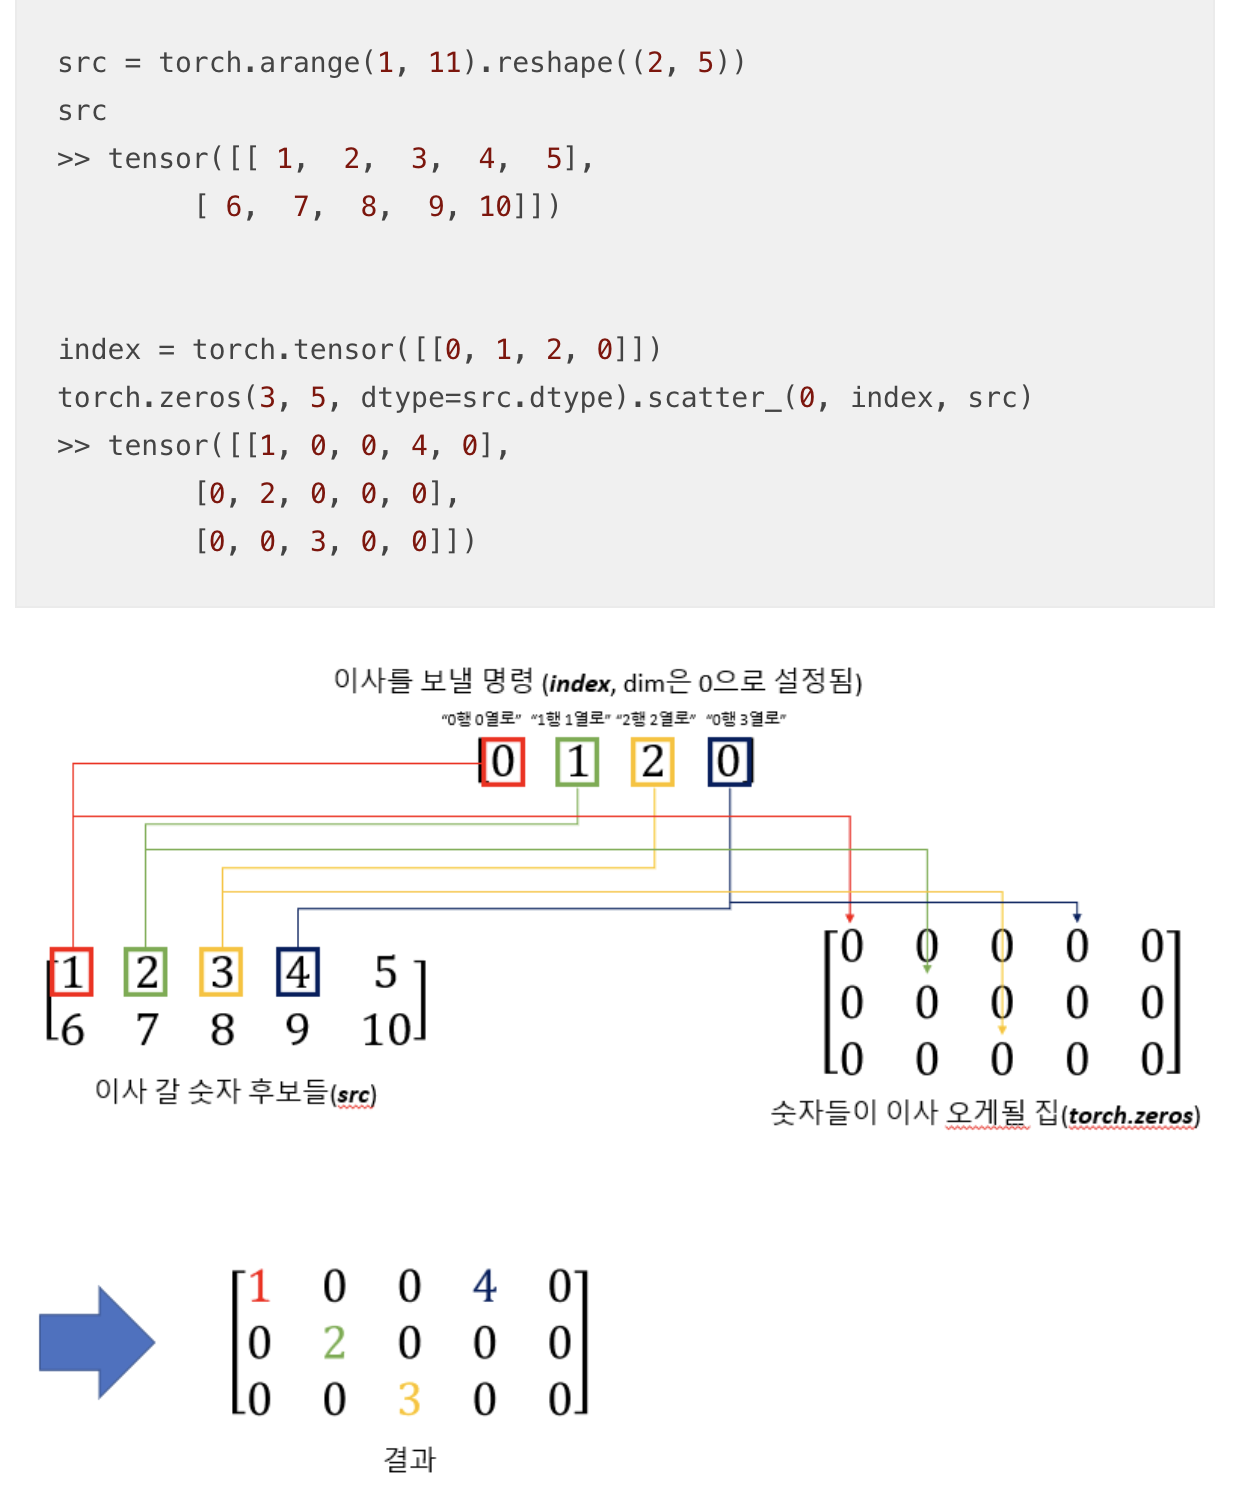


### Build The Neural Network  
NN(신경망)은 data에 대한 연산을 수행하는 layer와 module로 이뤄져 있음.  
torch.nn은 너의 NN에 필요한 building block(구성요소)을 제공해줌.  
그리고 파이토치의 모든 module은 nn.Module의 subclass임.  
NN은 다른 모듈, 다른 layer를 포함하고 있는 모듈이고. nested(중첩된)구조를 가지고 있음.  
이러한 nested structure는 more complex한 architecture 를 쉽게 구성할 수 있음.  




In [3]:
import os 
import torch
from torch import nn # 신경망 모듈
from torch.utils.data import DataLoader # 데이터셋을 반복하고 샘플링하는 기능을 제공
from torchvision import datasets,transforms # 이미지 데이터셋, 변환기능

# cuda 사용 가능 여부 확인 코드
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


#### Class를 정의합시다!  
we define our NN by subclassing `nn.Module` , and initialize NN with `__init__`.  
`nn.Module`을 상속받는 모든 class는 `forward 메소드`에 input에 대한 연산을 구현함.  

In [4]:
class NN(nn.Module): # nn.Module을 상속받아 신경망 모델을 정의
    def __init__(self): # 모델의 구조와 파라미터를 정의하는 생성자
        super(NN,self).__init__() # nn.Module의 생성자를 호출
        # super -> 부모 클래스의 생성자를 호출 -> 여기서 부모클래스는 nn.Module이고 
        # nn.Module(부모클래스)의 생성자를 호출하여 nn.Module의 속성을 가지고 초기화
        self.flatten = nn.Flatten()
        # Flatten은 이미지 데이터를 1차원으로 변환
        self.linear_relu_stack = nn.Sequential( # nn.Sequential은 순서대로 모듈을 쌓아서 순차적으로 실행
            nn.Linear(28*28,512),# 28*28개의 픽셀을 입력받아 512개의 픽셀로 출력
            # nn.Linear(input, output) -> 입력과 출력의 크기를 정의
            nn.ReLU(),# activation func
            nn.Linear(512,512),
            # 왜 굳이 512개의 픽셀을 입력받아 512개의 픽셀로 출력하는가?
            # 
            nn.ReLU(),
            nn.Linear(512,10),  
        )
    def forward(self,x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Torch에서 볼 수 있는 3가지 form의 flatten함수  
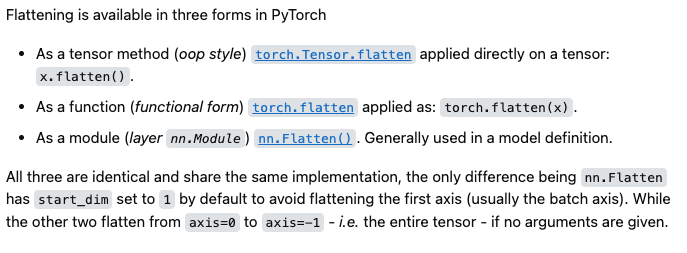  
위의 경우처럼 클래스를 구현할때는 보통 `nn.Flatten()`을 많이 씀. -> default start_dim이 1이라서 첫 axis를 flatten하는 대참사를 막아줄 수 있다넹  

아래 그림은 왜 같은 input, output의 함수가 필요한가에 대한 답변  
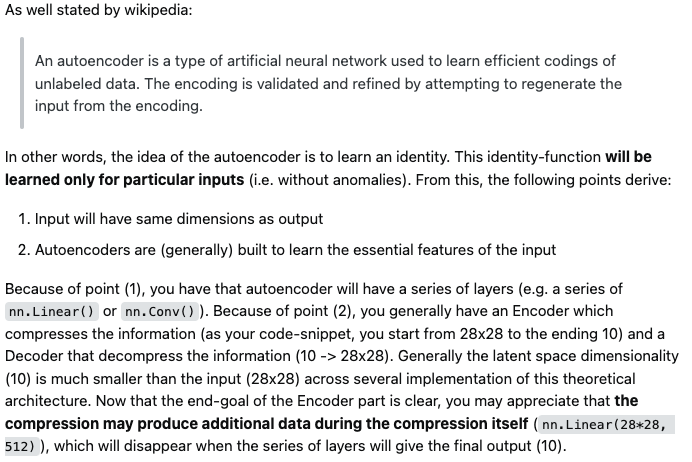  
오토인코더류의 함수에서는 항등함수(identity func)의 역할이 중요한데, 항등함수는 anomaly가 없는 상황에서 특정 입력에 대해서만 학습이 되기 때문에  
1. input will have same dimensions as output  
2. autoencoders are generally built to learn the essential features of the input   

https://stackoverflow.com/questions/75237257/what-is-the-purpose-of-having-the-same-input-and-output-in-pytorch-nn-linear-fun

In [5]:
model = NN().to(device)
print(model)

NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


to use the model, we pass it the input data. -> This executes the model's `forward` + 백그라운드 작업  
다만, model.forward()를 직접 호출하면 안됨!  -> 왜 직접 호출 하면 안되느냐? -> forward()에서는 모델에서 실행되어야 하는 계산을 정의함.  
backward()는 forward()의 역과정으로 지가 알아서 실행하기 때문에, forward만 정의해주면 되는데  


y = model(input) , y 는 2차원 Tensor  
2차원 Tensor의 dim=0

In [6]:
# 여기 코드 이해 잘 안감

X = torch.rand(1, 28, 28, device=device) # 1개의 샘플 데이터를 생성 -> 랜덤한 값으로 채워진 28*28의 이미지
# torch.rand : 0과 1사이의 랜덤한 값을 가지는 텐서를 생성
logits = model(X) # 여기서 model은 NN클래스의 인스턴스
pred_probab = nn.Softmax(dim=1)(logits) # dim=1은 각 행의 합이 1이 되도록 정규화, 즉 각 클래스에 대한 확률을 반환
#softmax(input, dim = 0) # normalizes values along axis 0
#softmax(input, dim = 1) # normalizes values along axis 1
# nn.Softmax == nn.functional.softmax
y_pred = pred_probab.argmax(1) # 가장 높은 확률을 가진 클래스의 인덱스를 반환
# 왜 argmax(1)인가? -> 각 행의 최대값의 인덱스를 반환
print(f"Predicted class: {y_pred}") # 예측된 클래스 출력

Predicted class: tensor([6])


In [7]:
input_image = torch.rand(3,28,28)# 3개의 샘플 데이터를 생성 -> 28*28크기의 이미지 3개로 구성된 미니배치
print(input_image.size())

torch.Size([3, 28, 28])


In [8]:
flatten = nn.Flatten() # Flatten은 이미지 데이터를 1차원으로 변환
flat_image = flatten(input_image)# 3*28*28 -> 3*784로 변환
print(flat_image.size())

torch.Size([3, 784])


In [9]:
layer1 = nn.Linear(in_features=28*28, out_features=20)# 784개의 픽셀을 입력받아 20개의 픽셀로 출력
hidden1 = layer1(flat_image)# 3*20으로 변환
print(hidden1.size())# 3*20

torch.Size([3, 20])


In [10]:
print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1) # ReLU activation func을 적용하고 나서 음수값은 싹 다 0으로 바뀐것을 볼 수 있음
print(f"After ReLU: {hidden1}")
# we use activation func to add nonlinearity to the model, which allows it to learn from complex data

Before ReLU: tensor([[-0.2291,  0.5730,  0.6247,  0.2683,  0.2373,  0.1648,  0.8878,  0.3891,
          0.3106, -0.5534,  0.1435,  0.1111, -0.0974,  0.3295,  0.0404,  0.1530,
          0.0366, -0.2803, -0.2026,  0.0643],
        [ 0.1876,  0.4821,  0.9142,  0.0912,  0.0447,  0.2021,  1.1200,  0.5689,
          0.1904, -0.4070,  0.0035, -0.0173,  0.0526,  0.1333,  0.1761,  0.3511,
          0.0227, -0.2411, -0.4504,  0.1285],
        [-0.1332,  0.2447,  0.3390,  0.1487,  0.3890, -0.1190,  1.2664,  0.5939,
          0.1810,  0.0907,  0.2893,  0.1957,  0.0551, -0.0322,  0.0852,  0.1769,
         -0.0446,  0.0441, -0.3375,  0.0748]], grad_fn=<AddmmBackward0>)


After ReLU: tensor([[0.0000, 0.5730, 0.6247, 0.2683, 0.2373, 0.1648, 0.8878, 0.3891, 0.3106,
         0.0000, 0.1435, 0.1111, 0.0000, 0.3295, 0.0404, 0.1530, 0.0366, 0.0000,
         0.0000, 0.0643],
        [0.1876, 0.4821, 0.9142, 0.0912, 0.0447, 0.2021, 1.1200, 0.5689, 0.1904,
         0.0000, 0.0035, 0.0000, 0.0526, 0.1333, 0.17

In [11]:
seq_modules = nn.Sequential(# nn.Sequential은 순서대로 모듈을 쌓아서 순차적으로 실행
    flatten,# 이미지 데이터를 1차원으로 변환
    layer1,# 784개의 픽셀을 입력받아 20개의 픽셀로 출력
    nn.ReLU(),# activation func
    nn.Linear(20, 10)# 20개의 픽셀을 입력받아 10개의 픽셀로 출력
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

In [12]:
softmax = nn.Softmax(dim=1) # dim=1 -> 각 행의 합이 1이 되도록 정규화, 즉 각 클래스에 대한 확률을 반환
# dim=0 -> 각 열의 합이 1이 되도록 정규화
pred_probab = softmax(logits)

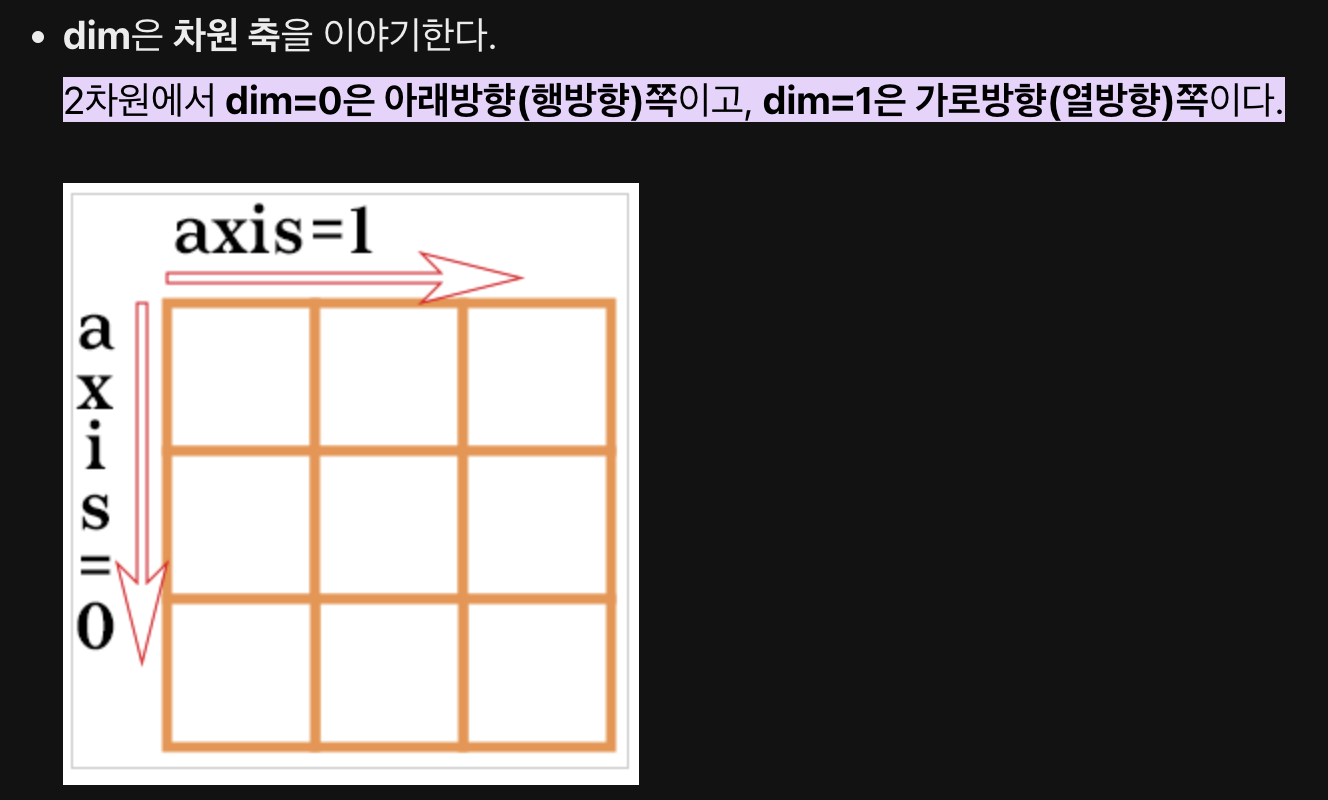

In [13]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Layer: linear_relu_stack.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0325, -0.0201, -0.0045,  ..., -0.0301,  0.0030, -0.0032],
        [-0.0109, -0.0223,  0.0149,  ..., -0.0083,  0.0069,  0.0084]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.0.bias | Size: torch.Size([512]) | Values : tensor([ 0.0006, -0.0315], grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.weight | Size: torch.Size([512, 512]) | Values : tensor([[ 0.0403,  0.0206,  0.0392,  ...,  0.0135, -0.0354,  0.0024],
        [-0.0336, -0.0083, -0.0118,  ..., -0.0163, -0.0179, -0.0218]],
       grad_fn=<SliceBackward0>) 

Layer: linear_relu_stack.2.bias | Size: torch

### ABOUT AutoGrad  
When training NN , the most frequently used algorithm is `back-prop`.   
이 알고리즘에선 parameter(weight)가 loss func의 gradient에 따라 조정됨.  
We use `torch.autograd` to compute these frequently.

In [14]:
import torch

x = torch.ones(5)  # input tensor 
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True) # weight
b = torch.randn(3, requires_grad=True)# bias
z = torch.matmul(x, w)+b# z = xw+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)# use loss func as binary cross entropy

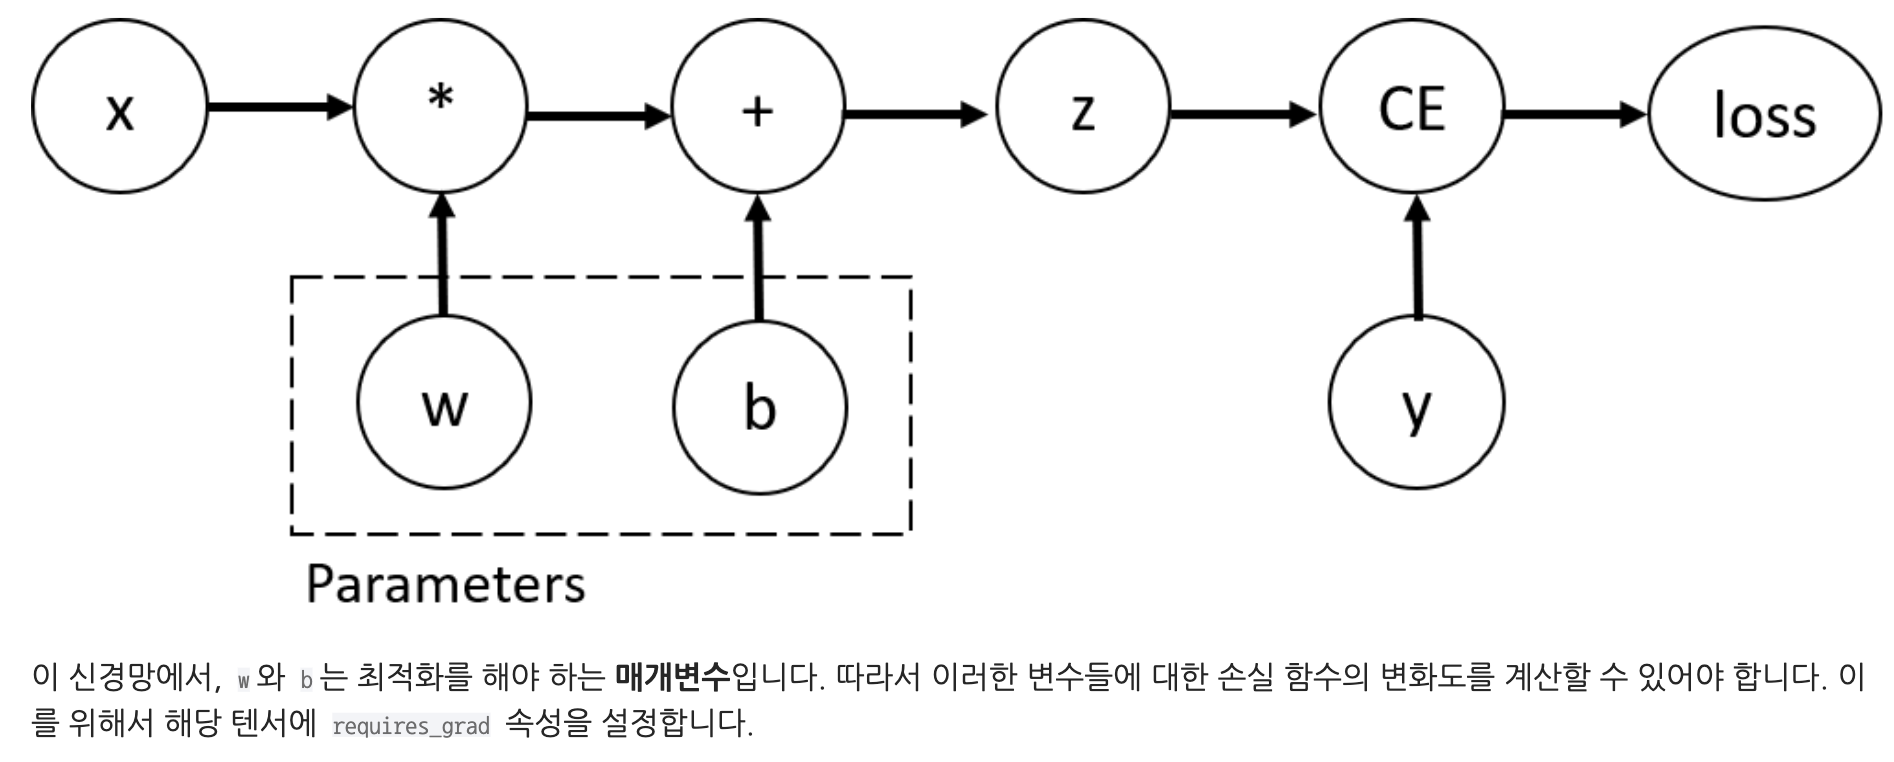

You can set the value of `requires_grad` when creating a tensor, or later by using x`.requires_grad_(True)` method.

In [15]:
print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")
# 위의 애들은 다 Function class의 객체라서 저렇게 출력이 되는거임

Gradient function for z = <AddBackward0 object at 0x7f85badf48e0>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x7f85badf46d0>


In [16]:
loss.backward()# loss func의 gradient를 계산
print(w.grad)# dloss/dw
print(b.grad)# dloss/db 

tensor([[0.2299, 0.2961, 0.1655],
        [0.2299, 0.2961, 0.1655],
        [0.2299, 0.2961, 0.1655],
        [0.2299, 0.2961, 0.1655],
        [0.2299, 0.2961, 0.1655]])
tensor([0.2299, 0.2961, 0.1655])


연산 그래프의 잎(leaf) 노드들 중 requires_grad 속성이 True로 설정된 노드들의 grad 속성만 구할 수 있습니다. 그래프의 다른 모든 노드에서는 변화도가 유효하지 않습니다.

성능 상의 이유로, 주어진 그래프에서의 backward를 사용한 변화도 계산은 한 번만 수행할 수 있습니다. 만약 동일한 그래프에서 여러번의 backward 호출이 필요하면, backward 호출 시에 retrain_graph=True를 전달해야 합니다.

In [17]:
z = torch.matmul(x, w)+b # z = xw+b
print(z.requires_grad)# True -> 기본적으로 requires_grad는 True로 설정되어 있음

with torch.no_grad():#자동적으로 gradient를 트래킹하지 않음 -> 즉, requires_grad=False
    # 학습이 다 끝나고 테스트만 필요할때는 backward연산이 필요하지 않으므로 메모리를 절약하기 위해 사용
    z = torch.matmul(x, w)+b
print(z.requires_grad)# False

True
False


In [18]:
# Another way to achieve the same result is to use the detach() method on the tensor:
z = torch.matmul(x, w)+b
z_det = z.detach() # detach()는  requires_grad 속성을 False로 설정하여 기존 Tensor 객체와 다르게 자동 미분 기능에서 제외됨
print(z_det.requires_grad)

False


Since, autograd keeps a record of data and all executed operation in a DAG(Directed Acyclic Graph) form,  
leaves -> input tensor  
roots -> output tensor  
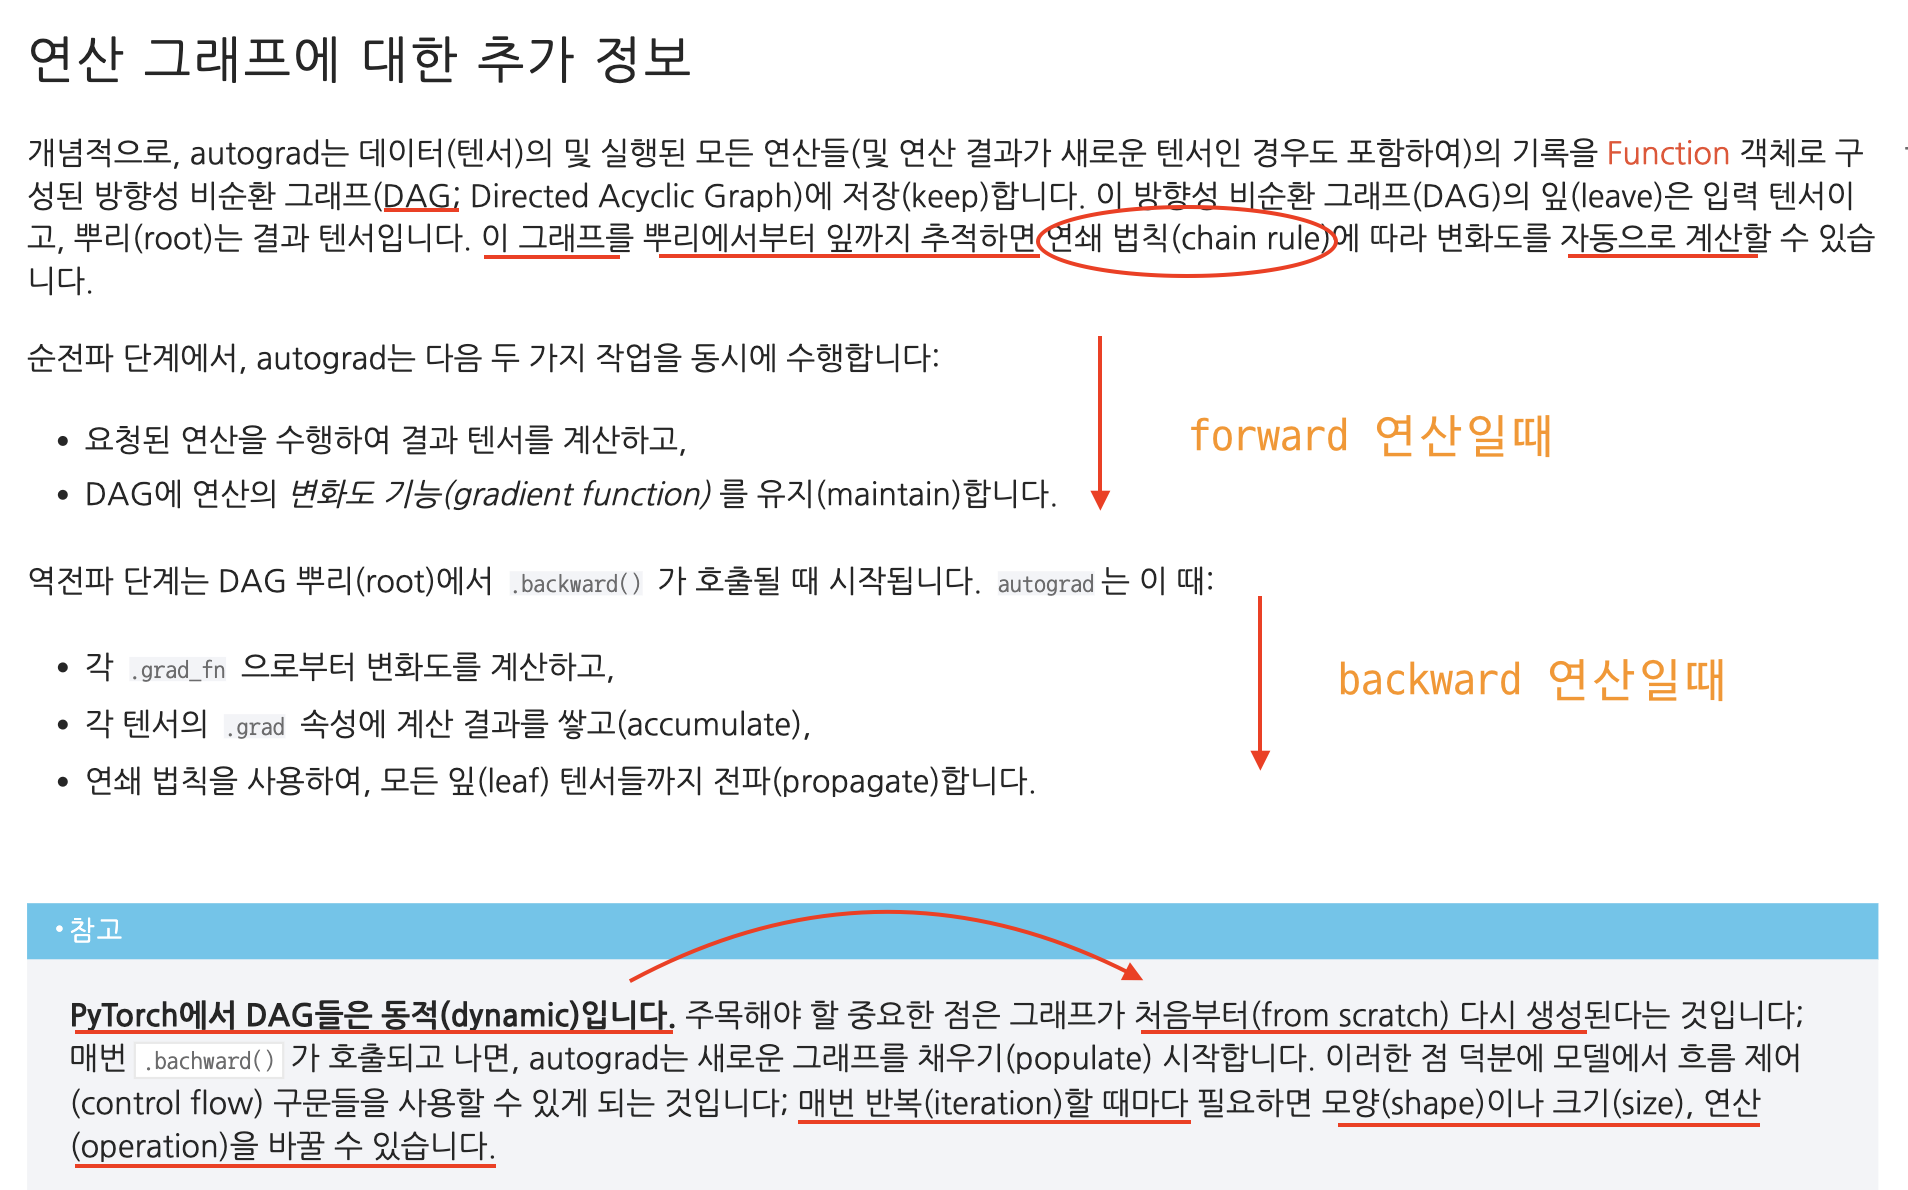



대부분 경우, loss func이 scalar form인데, 가끔 loss func의 output이 임의의 tensor일때가 있음.  
이때는 실제 gradient를 구하지 않고,  
Jacobian product(야코비안 곱)을 통해 구함.  
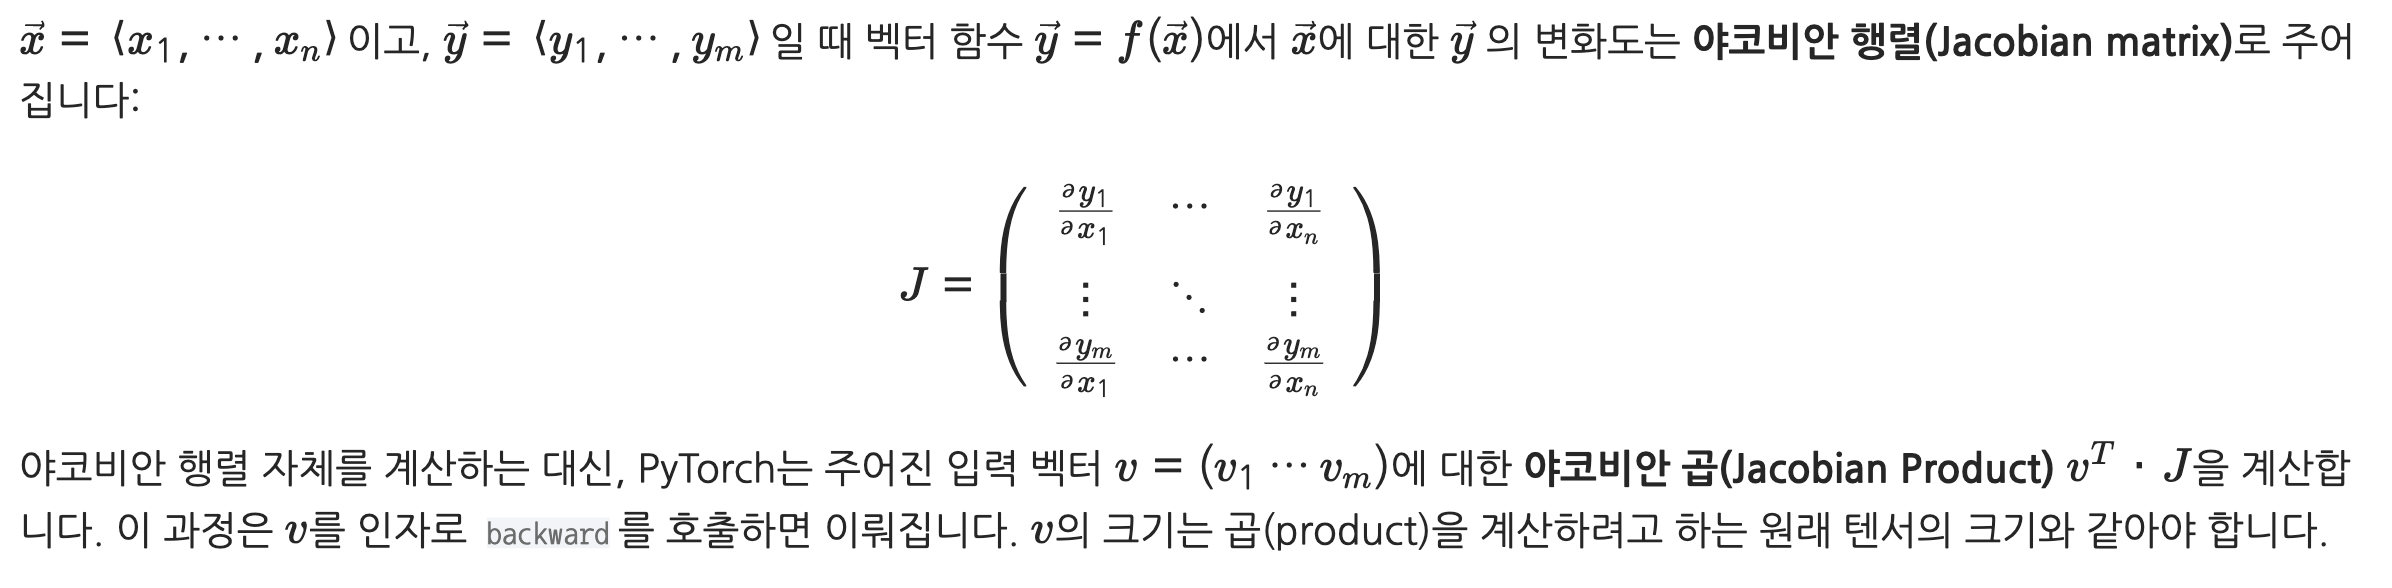

In [20]:
inp = torch.eye(4, 5, requires_grad=True)# 4*5의 단위행렬 , requires_grad=True -> gradient를 계산하겠다는 의미
out = (inp+1).pow(2).t()# (inp+1)^2의 전치행렬(transpose)
out.backward(torch.ones_like(out), retain_graph=True)# out에 대한 gradient를 계산, retain_graph=True -> backward를 여러번 호출할 수 있도록 함
print(f"First call\n{inp.grad}")# d(out)/d(inp)
out.backward(torch.ones_like(out), retain_graph=True)# out에 대한 gradient를 계산, retain_graph=True -> backward를 여러번 호출할 수 있도록 함
print(f"\nSecond call\n{inp.grad}")# d(out)/d(inp)
inp.grad.zero_()# gradient를 0으로 초기화, zero_()는 inplace 연산
out.backward(torch.ones_like(out), retain_graph=True)# out에 대한 gradient를 계산, retain_graph=True -> backward를 여러번 호출할 수 있도록 함
print(f"\nCall after zeroing gradients\n{inp.grad}")# d(out)/d(inp)

First call
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])

Second call
tensor([[8., 4., 4., 4., 4.],
        [4., 8., 4., 4., 4.],
        [4., 4., 8., 4., 4.],
        [4., 4., 4., 8., 4.]])

Call after zeroing gradients
tensor([[4., 2., 2., 2., 2.],
        [2., 4., 2., 2., 2.],
        [2., 2., 4., 2., 2.],
        [2., 2., 2., 4., 2.]])


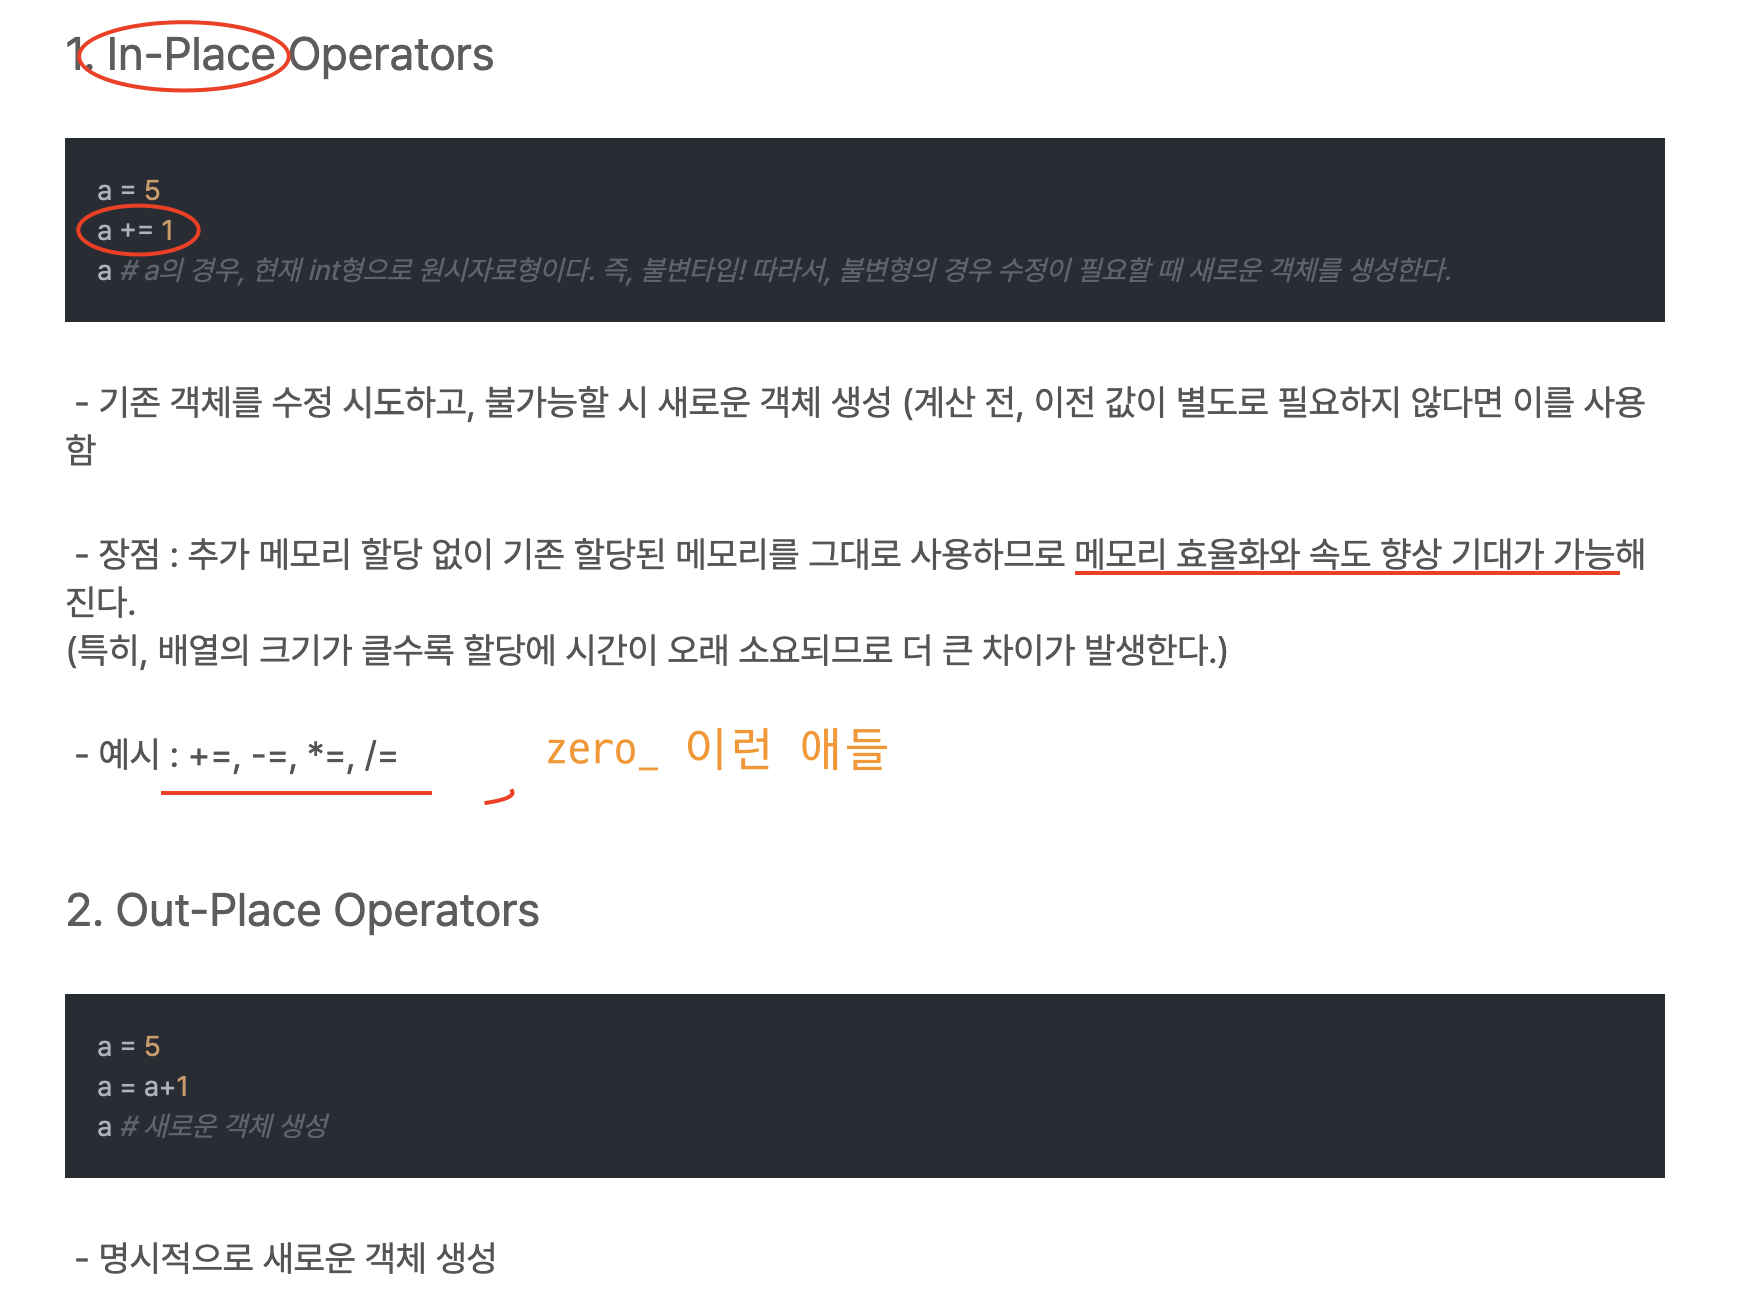